# Preliminary Summer Model Experiments (May - Aug?)
---
### *Timeline*
#### -- PART 1 (Base binary test) --

0. [ ] Import grid-placed houses with JS world edit - Tim
1. [ ] Create pure house dataset - Tim
2. [x] Create binary house dataset - Tim 
3. [ ] Test previous experiment models - M + Tim
    - [x] Original models (VAE, GAN) (M)
    - [x] New VAE (M)
    - [ ] New GAN (Tim)
    - [ ] New VAEGAN (M)
    
#### -- PART 2 (Block test) --

4. [ ] Use channels and repeat step #3

#### -- PART 3 (Full dataset test) --

5. [ ] Use the full dataset of buildings
    - 5a. If unsuccessful, problem is with "crazy" buildings - scrap altogether or try separate model (step #2+)
    - 5b. Else, continue anyways!

#### -- PART 4 (Fun experiments) --

6. Novelty experiments (see notebook: [link to notebook here])
7. Interactive evolution experiments (see notebook: [link to notebook here])
8. Latent space exploration experiments (see notebook: [link to notebook here])

In [6]:
DEBUG = True

---
### Imports

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from v1b.VAE16 import VAE_3D
import v1b.visualizer as vis
import v1b.preprocessing3Dcraft as preproc

%matplotlib inline

### Test Original Models

In [8]:
## VAE TEST
'''
-- Notes --
 > architecture isn't perfectly mirrored in layer sizes on encoder to decoder
 > takes a REALLY long time to train
'''
 
skip = True
if not skip:
    og_vae = VAE_3D()
    og_vae.train(epochs=500, batch_size=128)

### Make new visualizers

In [9]:
def show3D(builds, binary=True, textArr=None):
    fig = plt.figure(figsize=(20,7))
    col = 8
    
    if binary:
        colors = 'red'
    else:
        colors = 'red' #replace later with colors for each block id value [0-12]
    
    for i, build in enumerate(builds):
        ax = fig.add_subplot(int(len(builds) / col) + 1, col, i + 1,  projection='3d')
        ax.voxels(build, edgecolor="k", facecolors=colors, linewidth=0.5)
        plt.axis('off')
        if textArr != None:
            plt.title(textArr[i])
    plt.show()

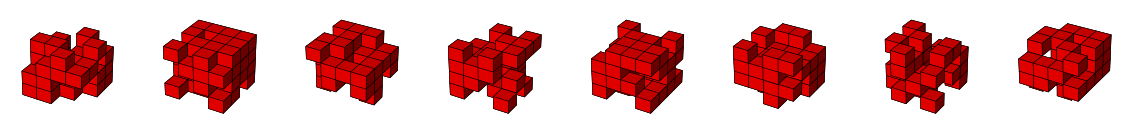

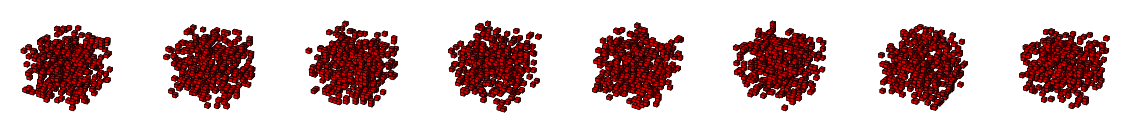

In [5]:
if DEBUG:
    n = 8
    rand_builds = [np.random.randint(0,2,size=(4,4,4)) for i in range(n)]
    rand_builds16 = [np.zeros(shape=(16,16,16)) for i in range(n)]

    # give random values for fun
    for i in range(n):
        for j in range(400):
            rand_builds16[i][random.randint(0,15)][random.randint(0,15)][random.randint(0,15)] = 1

    show3D(rand_builds)
    show3D(rand_builds16)

### Import the dataset

In [6]:
HOUSE_DATASET = []
HOUSE_DATASET_BIN = []
HOUSE_DATASET_BIN2 = []
HOUSE_DATASET_ONEHOT = []

house_combined = np.load('../ingame_house_schematics/old_format_schematic_files/combined.npy')
blocks = []
for h in house_combined:
    # houses look rotated... just rotate them back
    h = np.rot90(h,axes=(0,2))
    
    # remove bottom layer (got the ground as well) - i can't believe i got it right on the first try...
    h = h[3:, 3:, 1:-2]
    HOUSE_DATASET.append(h)
    
    
    #HOUSE_DATASET_ONEHOT.append(h)
    
    #hc = np.argmax(h,axis=2)
    #HOUSE_DATASET.append(hc)
    idx = np.nonzero(h)
    hb = np.zeros(shape=h.shape)
    for i in range(len(idx[0])):
        a,b,c = idx
        hb[a[i]][b[i]][c[i]] = 1
    HOUSE_DATASET_BIN.append(hb)
    
    hb2 = np.copy(hb)
    hb2[hb2 == 0] = -1
    hb2[hb2 == 1] = 2
    HOUSE_DATASET_BIN2.append(hb2)
        
HOUSE_DATASET = np.array(HOUSE_DATASET)
HOUSE_DATASET_BIN = np.array(HOUSE_DATASET_BIN)
HOUSE_DATASET_ONEHOT = np.array(HOUSE_DATASET_ONEHOT)

In [7]:
print(np.array(HOUSE_DATASET_BIN[0]).shape)
print(np.unique(HOUSE_DATASET_BIN[0]))

print(np.array(HOUSE_DATASET_BIN2[0]).shape)
print(np.unique(HOUSE_DATASET_BIN2[0]))

(16, 16, 16)
[0. 1.]
(16, 16, 16)
[-1.  2.]


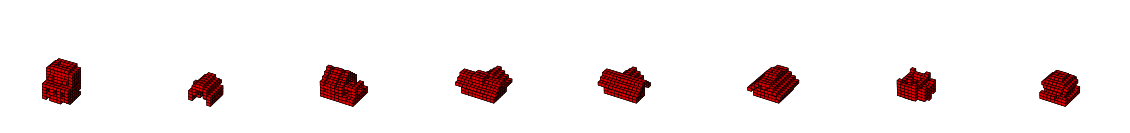

In [8]:
# show a few random ones to verify
if DEBUG:
    show3D(HOUSE_DATASET_BIN[random.choices(list(range(len(HOUSE_DATASET_BIN))),k=8)])

### Try new models

**VAE Test** 
- taken from AestheticBot prelim experiments -> taken from Diversity + NoveltyPrints project
- modified to be in 3d

In [19]:
from keras.models import Model
from keras import backend as K
from keras import Input
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Conv3DTranspose, LeakyReLU, Reshape, ReLU, Conv3D, Flatten, MaxPooling3D

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        mean_mu, log_var = inputs
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon
    

class VAE(Model):
    def __init__(self,zshape,batches=1,channels=1):
        super(VAE, self).__init__()
        
        self.channels = channels
        self.latent_dim = zshape
        self.batch_size = batches
        self.nn_size = 16
        
        #make the models
        self.makeEncoder()
        self.makeDecoder()
        
    #makes the encoder model for the VAE
    def makeEncoder(self):
        
        #variational encoder
        enc_in = Input(shape=(self.nn_size, self.nn_size, self.nn_size, self.channels))
        x = Conv3D(self.channels*2, kernel_size=2, padding='same', strides=2)(enc_in)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU()(x)
        x = Conv3D(self.channels*4, kernel_size=2, padding='same', strides=2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU()(x)
#         x = Conv3D(self.channels*8, kernel_size=2, padding='same', strides=2)(x)
#         x = LeakyReLU()(x)
        x = Flatten()(x)
        
        #variational sampling
        z_mean = Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
            
        #combine together
        self.encoder = Model(enc_in, [z_mean, z_log_var, z], name='encoder')
        
        if DEBUG:
            self.encoder.summary()
        
    #makes the decoder model for the VAE
    def makeDecoder(self):
        #normal decoder
        dec_in = Input(shape=(self.latent_dim,))
        s = self.nn_size//4
        y = Dense(s*s*s*4*self.channels, activation="relu")(dec_in)  #product of output shape of autoencoder
        y = Reshape((s,s,s,4*self.channels))(y)  #output shape of autoencoder
        
        
#         s = self.nn_size//8
#         y = Dense(s*s*s*8*self.channels, activation="relu")(dec_in)  #product of output shape of autoencoder
#         y = Reshape((s,s,s,8*self.channels))(y)  #output shape of autoencoder
#         y = Conv3DTranspose(self.channels*4, kernel_size=4, strides=2, padding='same')(y)
#         y = LeakyReLU()(y)
        y = Conv3DTranspose(self.channels*2, kernel_size=2, strides=2, padding='same')(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU()(y)
        y = Conv3DTranspose(self.channels, kernel_size=2, strides=2, padding='same')(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU()(y)
        dec_out = Conv3DTranspose(self.channels, kernel_size=3, activation='sigmoid', padding='same')(y)
        self.decoder = Model(dec_in, dec_out)

        
        if DEBUG:
            self.decoder.summary()
     
    #define loss functions
    
    #reconstructed loss
    def r_loss(self,y_true, y_pred):
#         return K.mean(K.square(tf.cast(y_true,tf.float32) - tf.cast(y_pred,tf.float32)), axis = [1,2,3])
        return tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1,2,3)))
        
    #kl-divergence loss
    def kl_loss(self,log_var, mean):
#         return -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
        kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=(1)))
        return kl_loss
    
    #singular step for training
    def train_step(self, data):    
        with tf.GradientTape() as tape:
            #get output encoding and reconstruct from latent vector
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            #VAE loss function - MSE + KL DIVERGENCE
            reconstruction_loss = self.r_loss(data,reconstruction)
            kl = self.kl_loss(z_log_var,z_mean)
#             tl = 10000*reconstruction_loss+kl
            tl = reconstruction_loss+kl
             
        #apply loss back to weights
        grads = tape.gradient(tl, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {"recon loss":reconstruction_loss, "kl loss":kl, "total loss": tl}

In [20]:
# VAE TEST

#setup
EPOCHS = 200   #training longer gets better reconstruction
BATCH_SIZE = 32
Z_SIZE = 25
CHANNELS = 1

if CHANNELS == 11:
    INPUT_DATA = HOUSE_DATASET_ONEHOT
else:
    INPUT_DATA = np.expand_dims(HOUSE_DATASET_BIN,axis=4)
    

#create batch data
train_dat = tf.data.Dataset.from_tensor_slices(INPUT_DATA).shuffle(len(INPUT_DATA)).batch(BATCH_SIZE)

# create the VAE
HOUSE_VAE = VAE(Z_SIZE,BATCH_SIZE,CHANNELS)
HOUSE_VAE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

# train the VAE
history = HOUSE_VAE.fit(train_dat,epochs=EPOCHS,batch_size=BATCH_SIZE,shuffle=True,verbose=True)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 16, 16, 16,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_6 (Conv3D)              (None, 8, 8, 8, 2)   18          ['input_7[0][0]']                
                                                                                                  
 batch_normalization_12 (BatchN  (None, 8, 8, 8, 2)  8           ['conv3d_6[0][0]']               
 ormalization)                                                                                    
                                                                                            

5/5 [==============================] - 0s 84ms/step - recon loss: 575.4100 - kl loss: 28.8162 - total loss: 604.2263
Epoch 86/200
5/5 [==============================] - 0s 55ms/step - recon loss: 555.7243 - kl loss: 29.1004 - total loss: 584.8247
Epoch 87/200
5/5 [==============================] - 0s 55ms/step - recon loss: 543.3081 - kl loss: 30.4555 - total loss: 573.7636
Epoch 88/200
5/5 [==============================] - 0s 57ms/step - recon loss: 544.3981 - kl loss: 30.1327 - total loss: 574.5308
Epoch 89/200
5/5 [==============================] - 0s 56ms/step - recon loss: 549.0028 - kl loss: 29.7976 - total loss: 578.8004
Epoch 90/200
5/5 [==============================] - 0s 55ms/step - recon loss: 512.9459 - kl loss: 30.9370 - total loss: 543.8830
Epoch 91/200
5/5 [==============================] - 0s 56ms/step - recon loss: 522.7891 - kl loss: 30.9557 - total loss: 553.7448
Epoch 92/200
5/5 [==============================] - 0s 93ms/step - recon loss: 521.0821 - kl loss: 30.7

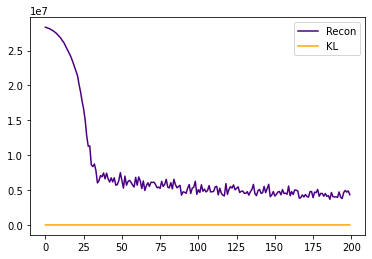

In [21]:
plt.plot(np.array(history.history['recon loss']).squeeze()*10000,label=f'Recon',color='indigo')
plt.plot(np.array(history.history['kl loss']).squeeze(),label=f'KL',color='orange')
plt.legend()

In [22]:
# show reconstruction from the VAE
def reconVAETest(vae_model,testData):
    # get prediction output
    encoded_imgs = vae_model.encoder.predict(testData)
    decoded_imgs = np.around(vae_model.decoder.predict(encoded_imgs[2]).squeeze())
    
    # show the two outputs on top of each other
    show3D(testData.squeeze())
    show3D(decoded_imgs)
    
# generate and show new sample from the VAE
def generateVAESamples(vae_model,n=8,zsize=20):
    vae_samples = np.around(vae_model.decoder.predict(np.random.normal(0,1,size=(n,zsize))).squeeze())
    show3D(vae_samples)

RECON
1/1 [==============================] - 0s 221ms/step


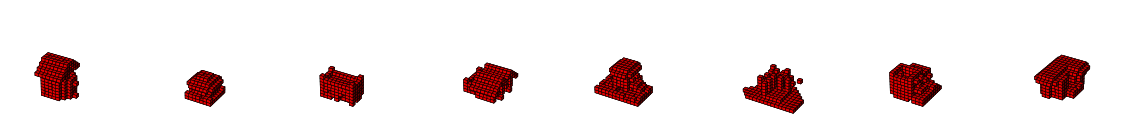

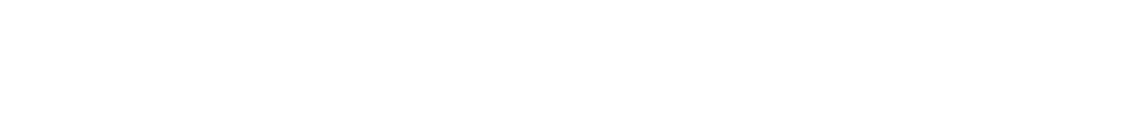

SAMPLE
1/1 [==============================] - 0s 25ms/step


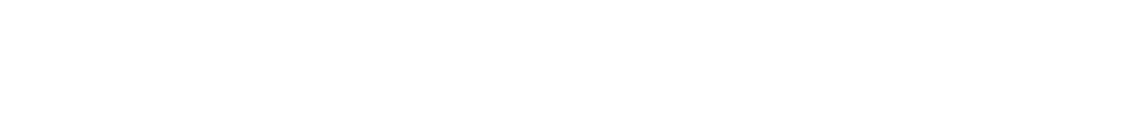

In [23]:
if DEBUG:
    print("RECON")
    rand_index = random.choices(list(range(len(INPUT_DATA))),k=8)
    RAND_SEL = INPUT_DATA[rand_index]
    reconVAETest(HOUSE_VAE,RAND_SEL)
    
    print("SAMPLE")
    generateVAESamples(HOUSE_VAE,zsize=Z_SIZE)

### 3D-VAE Modification (from https://arxiv.org/pdf/1608.04236.pdf  and https://github.com/IsaacGuan/3D-VAE)

In [ ]:
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2


def weighted_binary_crossentropy(target, output):
    t2 = tf.cast(target,tf.float32)
    o2 = tf.cast(output,tf.float32)
    loss = -(98.0 * t2 * K.log(o2) + 2.0 * (1.0 - t2) * K.log(1.0 - o2)) / 100.0
    return loss

learning_rate_1 = 0.0001
learning_rate_2 = 0.005

def learning_rate_scheduler(epoch, lr):
    if epoch >= 1:
        lr = learning_rate_2
    return lr

class VAE_Mod(Model):
    def __init__(self,zshape,batches=1,channels=1):
        super(VAE_Mod, self).__init__()
        
        self.channels = channels
        self.latent_dim = zshape
        self.batch_size = batches
        self.nn_size = 16
        
        #make the models
        self.makeEncoder()
        self.makeDecoder()
        
    #makes the encoder model for the VAE
    def makeEncoder(self):
        
        #variational encoder
        enc_in = Input(shape=(self.nn_size, self.nn_size, self.nn_size, self.channels))
        x = BatchNormalization()(enc_in)
        x = Conv3D(self.channels*8, kernel_size=3, strides=1, padding='valid', activation='elu', kernel_initializer = 'glorot_normal')(x)
        x = BatchNormalization()(x)
        x = Conv3D(self.channels*16, kernel_size=3, strides=2, padding='same', activation='elu', kernel_initializer = 'glorot_normal')(x)
        x = BatchNormalization()(x)
        x = Conv3D(self.channels*32, kernel_size=3, strides=1, padding='valid', activation='elu', kernel_initializer = 'glorot_normal')(x)
        x = BatchNormalization()(x)
        x = Conv3D(self.channels*64, kernel_size=3, strides=2, padding='same', activation='elu', kernel_initializer = 'glorot_normal')(x)
        x = BatchNormalization()(x)
        x = Flatten()(x)
        x = Dense(27,kernel_initializer = 'glorot_normal',activation = 'elu')(x)
        x = BatchNormalization()(x)
        
        #variational sampling
        z_mean = Dense(self.latent_dim, name="z_mean",activation=None)(x)
        z_log_var = Dense(self.latent_dim, name="z_log_var",activation=None)(x)
        z = Sampling()([z_mean, z_log_var])
            
        #combine together
        self.encoder = Model(enc_in, [z_mean, z_log_var, z], name='encoder')
        
        if DEBUG:
            self.encoder.summary()
        
    #makes the decoder model for the VAE
    def makeDecoder(self):
        #normal decoder
        dec_in = Input(shape=(self.latent_dim,))
        y = BatchNormalization()(dec_in)
        y = Dense(27, activation="elu", kernel_initializer = 'glorot_normal')(y)  #product of output shape of autoencoder
        y = Reshape((3,3,3,self.channels))(y)  #output shape of autoencoder
        y = BatchNormalization()(y)
        y = Conv3DTranspose(self.channels*64, kernel_size=3, strides=1, padding='same', activation='elu', kernel_initializer = 'glorot_normal')(y)
        y = BatchNormalization()(y)
        y = Conv3DTranspose(self.channels*32, kernel_size=3, strides=2, padding='valid', activation='elu', kernel_initializer = 'glorot_normal')(y)
        y = BatchNormalization()(y)
        y = Conv3DTranspose(self.channels*16, kernel_size=3, strides=1, padding='same', activation='elu', kernel_initializer = 'glorot_normal')(y)
        y = BatchNormalization()(y)
        y = Conv3DTranspose(self.channels*8, kernel_size=4, strides=2, padding='valid', activation='elu', kernel_initializer = 'glorot_normal')(y)
        y = BatchNormalization(beta_regularizer = l2(0.001),gamma_regularizer = l2(0.001))(y)
        dec_out = Conv3DTranspose(self.channels, kernel_size=3, strides=1, padding='same', activation='sigmoid', kernel_initializer = 'glorot_normal')(y)
        self.decoder = Model(dec_in, dec_out)

        
        if DEBUG:
            self.decoder.summary()
            
    #reconstructed loss
    def r_loss(self,y_true, y_pred):
#         return K.mean(K.square(tf.cast(y_true,tf.float32) - tf.cast(y_pred,tf.float32)), axis = [1,2,3])
        return tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1,2,3)))
        
    #kl-divergence loss
    def kl_loss(self,log_var, mean):
#         return -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
        kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=(1)))
        return kl_loss
     

    #singular step for training
    def train_step(self, data):    
        with tf.GradientTape() as tape:
            #get output encoding and reconstruct from latent vector
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            #VAE loss function - BCE + KL DIVERGENCE
#             reconstruction_loss = self.r_loss(data,reconstruction)
#             kl = self.kl_loss(z_log_var,z_mean)
#             tl = reconstruction_loss+kl
            
#             reconstruction_loss = K.cast(tf.reduce_mean(tf.reduce_sum(weighted_binary_crossentropy(data,reconstruction), axis=(1,2,3)),axis=0), 'float32')
#             kl = K.cast(K.mean(-0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),axis=1), axis = 0), 'float32')
#             tl = reconstruction_loss+kl
            
#             reconstruction_loss = K.cast(tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1,2,3),axis=0)), 'float32')
#             kl = K.cast(K.mean(-0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),axis=1), axis = 0), 'float32')
#             tl = reconstruction_loss+kl
                
            kl = -0.5 * K.mean(1 + 2 * z_log_var - K.square(z_mean) - K.exp(2 * z_log_var))
#             reconstruction_loss = K.sum(weighted_binary_crossentropy(data, K.clip(sigmoid(reconstruction), 1e-7, 1.0 - 1e-7)),axis=(1,2,3))
#             reconstruction_loss = K.cast(K.mean(reconstruction_loss), 'float32')
            reconstruction_loss = K.cast(K.mean(weighted_binary_crossentropy(data, K.clip(sigmoid(reconstruction), 1e-7, 1.0 - 1e-7)),axis=(1,2,3)), 'float32')
#             reconstruction_loss = K.cast(K.mean(weighted_binary_crossentropy(data, K.clip(reconstruction, 1e-7, 1.0 - 1e-7)),axis=(1,2,3)), 'float32')
#             tl = reconstruction_loss+kl

            tl = reconstruction_loss + kl
             
        #apply loss back to weights
        grads = tape.gradient(tl, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {"recon loss":reconstruction_loss, "kl loss":kl, "total loss": tl}

In [ ]:
# VAE TEST

#setup
EPOCHS = 200   #training longer gets better reconstruction
BATCH_SIZE = 16
Z_SIZE = 20
CHANNELS = 1

if CHANNELS == 11:
    INPUT_DATA = HOUSE_DATASET_ONEHOT
else:
    INPUT_DATA = np.expand_dims(HOUSE_DATASET_BIN2,axis=4)
    

#create batch data
train_dat = tf.data.Dataset.from_tensor_slices(INPUT_DATA).shuffle(len(INPUT_DATA)).batch(BATCH_SIZE)

# create the VAE
HOUSE_VAE_MOD = VAE_Mod(Z_SIZE,BATCH_SIZE,CHANNELS)
#HOUSE_VAE_MOD.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))
HOUSE_VAE_MOD.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9, nesterov = True), metrics = ['accuracy'])

# train the VAE
history = HOUSE_VAE_MOD.fit(train_dat,epochs=EPOCHS,batch_size=BATCH_SIZE,shuffle=True,verbose=True,callbacks = [LearningRateScheduler(learning_rate_scheduler)])



In [ ]:
plt.plot(np.array(history.history['recon loss']).squeeze(),label=f'Recon',color='indigo')
plt.plot(np.array(history.history['kl loss']).squeeze(),label=f'KL',color='orange')
plt.legend()

In [ ]:
# show reconstruction from the VAE (using alt dataset)
def reconVAETest2(vae_model,testData):
    # get prediction output
    encoded_imgs = vae_model.encoder.predict(testData)
    decoded_imgs = vae_model.decoder.predict(encoded_imgs[2]).squeeze()
    
    # show the two outputs on top of each other
    testData2 = np.copy(testData)
    testData2[testData2<0] = 0
    testData2[testData2>0] = 1
    
    decoded_imgs[decoded_imgs<0] = 0
    decoded_imgs[decoded_imgs>0] = 1
    
    show3D(testData2.squeeze())
    show3D(decoded_imgs)
    
# generate and show new sample from the VAE (using alt dataset)
def generateVAESamples2(vae_model,n=8,zsize=20):
    vae_samples = vae_model.decoder.predict(np.random.normal(0,1,size=(n,zsize))).squeeze()
    
    vae_samples[vae_samples<0] = 0
    vae_samples[vae_samples>0] = 1
    
    show3D(vae_samples)

In [ ]:
if DEBUG:
    print("RECON")
    rand_index = random.choices(list(range(len(INPUT_DATA))),k=8)
    RAND_SEL = INPUT_DATA[rand_index]
    reconVAETest2(HOUSE_VAE_MOD,RAND_SEL)
    
    print("SAMPLE")
    generateVAESamples2(HOUSE_VAE_MOD,zsize=Z_SIZE)

In [ ]:
# To try
'''
    - interpolation between reconstructive vectors
    - 3 model pipeline: binary architecture, cateogrical blocks, decoration
    - vector vae (dall-e)
    

'''

### Mini AutoEncoder try (from https://github.com/kdj842969/3D-Autoencoder)

In [71]:
class Mini_AE(Model):
    def __init__(self,batches=16,channels=1):
        super(Mini_AE, self).__init__()
        
        self.channels = channels
        self.batch_size = batches
        self.nn_size = 16
        
        #make the models
        self.makeModel()
        
    def makeModel(self):
        input_img = Input(shape=(32, 32, 32, 1))
        x = Conv3D(30, (5, 5, 5), activation='relu', padding='same')(input_img)
        x = MaxPooling3D((2, 2, 2), padding='same')(x)
        x = Conv3D(60, (5, 5, 5), activation='relu', padding='same')(x)
        encoded = MaxPooling3D((2, 2, 2), padding='same')(x)
        
        x = Conv3D(60, (5, 5, 5), activation='relu', padding='same')(encoded)
        x = tf.keras.layers.UpSampling3D((2, 2, 2))(x)
        x = Conv3D(30, (5, 5, 5), activation='relu', padding='same')(x)
        x = tf.keras.layers.UpSampling3D((2, 2, 2))(x)
        decoded = Conv3D(1, (5, 5, 5), activation='relu', padding='same')(x)
        
        self.autoencoder = Model(input_img, decoded)
        
    def train(self,train_dat,EPOCHS=200):
        
        self.autoencoder.summary()
        self.autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
        self.autoencoder.fit(train_dat,train_dat,epochs=EPOCHS,batch_size=self.batch_size)

In [100]:
# double the size of the houses (16,16,16) -> (32,32,32) [manually done because no good function exists -_-]
DOUBLE_HOUSES = []
for h in INPUT_DATA:
    h2 = h.squeeze()
    dh = np.zeros(shape=(32,32,32))
    m = [(0,0,0),(1,0,0),(0,1,0),(0,0,1),(1,1,0),(0,1,1),(1,0,1),(1,1,1)]
    for x in range(16):
        for y in range(16):
            for z in range(16):
                v = h2[x][y][z]
                if v == 0:
                    continue
                for mi in m:
                    dh[x*2+mi[0]][y*2+mi[1]][z*2+mi[2]] = v
    DOUBLE_HOUSES.append(dh)
DOUBLE_HOUSES = np.expand_dims(DOUBLE_HOUSES,axis=-1)

In [101]:
print(np.unique(INPUT_DATA[0]))
print(np.unique(DOUBLE_HOUSES[0]))

[0. 1.]
[0. 1.]


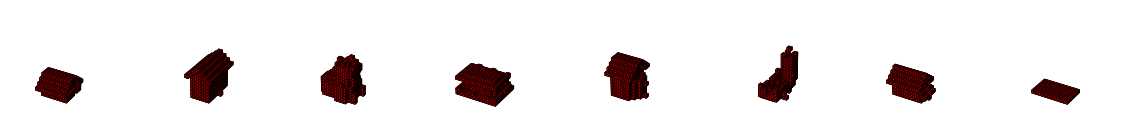

In [98]:
show3D(np.array(random.choices(DOUBLE_HOUSES,k=8)).squeeze())

In [104]:
voxel_ae = Mini_AE(batches=8)
voxel_ae.train(DOUBLE_HOUSES)

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 32, 32, 32, 1)]   0         
                                                                 
 conv3d_60 (Conv3D)          (None, 32, 32, 32, 30)    3780      
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 16, 16, 16, 30)   0         
 g3D)                                                            
                                                                 
 conv3d_61 (Conv3D)          (None, 16, 16, 16, 60)    225060    
                                                                 
 max_pooling3d_33 (MaxPoolin  (None, 8, 8, 8, 60)      0         
 g3D)                                                            
                                                                 
 conv3d_62 (Conv3D)          (None, 8, 8, 8, 60)       450

KeyboardInterrupt: 

In [ ]:
def reconAETest(ae_model,testData):
    # get prediction output
    decoded_imgs = ae_model.autoencoder.predict(testData).squeeze()
    
    # show the two outputs on top of each other
#     testData2 = np.copy(testData)
#     testData2[testData2<0] = 0
#     testData2[testData2>0] = 1
    
#     decoded_imgs[decoded_imgs<0] = 0
#     decoded_imgs[decoded_imgs>0] = 1
    
    show3D(testData.squeeze())
    show3D(decoded_imgs)
    
print("RECON")
rand_index = random.choices(list(range(len(INPUT_DATA))),k=8)
RAND_SEL = INPUT_DATA[rand_index]
reconAETest(voxel_ae,RAND_SEL)

In [ ]:
### Try same 

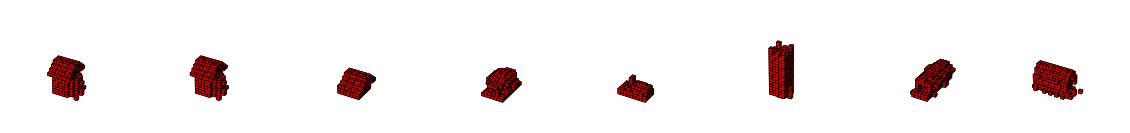

In [25]:
HOUSE_DATASET2 = []
HOUSE_DATASET_BIN2 = []

house_combined2 = np.load('../ingame house schematics/combined_blocknames.npy',allow_pickle=True)
for h in house_combined2:
    # houses look rotated... just rotate them back
    h = np.rot90(h,axes=(0,2))
    
    # remove bottom layer (got the ground as well) - i can't believe i got it right on the first try...
    h = h[:, :, 1:]
    HOUSE_DATASET2.append(h)
    
    h3d = np.zeros(shape=h.shape)
    for x in range(h.shape[0]):
        for y in range(h.shape[1]):
            for z in range(h.shape[2]):
                if h[x][y][z] != "minecraft:air":
                    h3d[x][y][z] = 1
    HOUSE_DATASET_BIN2.append(h3d)

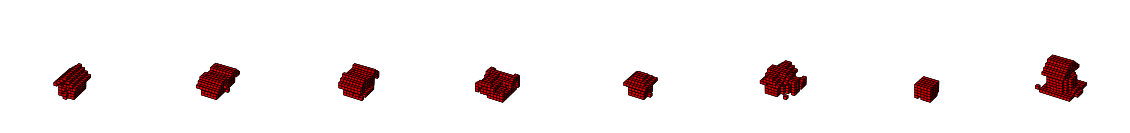

In [26]:
show3D(random.choices(HOUSE_DATASET_BIN2,k=8))

In [22]:
print(np.unique(HOUSE_DATASET2[0]))
print(np.array(HOUSE_DATASET2).shape)

['minecraft:air' 'minecraft:blast_furnace[facing=north,lit=false]'
 'minecraft:bricks' 'minecraft:cobblestone'
 'minecraft:cobblestone_stairs[facing=east,half=bottom,shape=outer_left,waterlogged=false]'
 'minecraft:cobblestone_stairs[facing=east,half=bottom,shape=straight,waterlogged=false]'
 'minecraft:cobblestone_stairs[facing=north,half=bottom,shape=straight,waterlogged=false]'
 'minecraft:cobblestone_stairs[facing=south,half=bottom,shape=straight,waterlogged=false]'
 'minecraft:cobblestone_stairs[facing=west,half=bottom,shape=outer_right,waterlogged=false]'
 'minecraft:cobblestone_stairs[facing=west,half=bottom,shape=straight,waterlogged=false]'
 'minecraft:cobblestone_wall[east=none,north=none,south=none,up=true,waterlogged=false,west=none]'
 'minecraft:glass_pane[east=false,north=true,south=true,waterlogged=false,west=false]'
 'minecraft:glass_pane[east=true,north=false,south=false,waterlogged=false,west=true]'
 'minecraft:jigsaw[orientation=west_up]'
 'minecraft:oak_door[facing=